## Clip Dynamic GT and nuScenes

In [43]:
import cv2
import numpy as np
import os

In [44]:
import glob

type = 'static'
# type = 'dynamic'
model_input_folder = '/home/pak/vkr/data/datasets/nuscenes/nuscenes_mini/samples/CAM_FRONT'
model_output_folder = '/home/pak/vkr'
model_gt_folder = f'/home/pak/vkr/data/datasets/nuscenes/nuscenes_mini/{type}_gt'

In [45]:
sorted_input_names = sorted(glob.glob(f'{model_input_folder}/**.jpg', recursive=True))

image_sample = cv2.imread(sorted_input_names[0])

height = image_sample.shape[0]
width = image_sample.shape[0]

size = (image_sample.shape[1] + image_sample.shape[0], image_sample.shape[0])

In [42]:
fps = 5
out = cv2.VideoWriter(model_output_folder + '/fetched.avi', cv2.VideoWriter_fourcc(*'DIVX'), fps, size)

for img_index, img_path in enumerate(sorted_input_names):    
    input_image = cv2.imread(img_path)
    gt_image = cv2.imread(img_path.replace('samples/CAM_FRONT', f'{type}_gt'))
        
    gt_image = cv2.resize(
        gt_image, dsize=(height, width), interpolation=cv2.INTER_CUBIC
    )
    data = np.concatenate((input_image, gt_image), 1)
    out.write(data)
out.release()

## Clip static+dynamic video

In [ ]:
sorted_input_names = sorted(glob.glob(f'{model_input_folder}/**.jpg', recursive=True))
sorted_static_names = sorted(glob.glob(f'{model_output_folder}/static/**.png', recursive=True))

image_sample = cv2.imread(sorted_input_names[0])
static_sample = cv2.imread(sorted_static_names[0])
dynamic_sample = cv2.imread(sorted_static_names[0].replace('static', 'dynamic'))

height = image_sample.shape[0]
width = image_sample.shape[0]

size = (image_sample.shape[1] + image_sample.shape[0], image_sample.shape[0])

In [ ]:
fps = 5
out = cv2.VideoWriter(model_output_folder + '/fetched.avi', cv2.VideoWriter_fourcc(*'DIVX'), fps, size)

for img_index, img_path in enumerate(sorted_static_names):
    assert img_path.split('_')[-1][:-3] == sorted_input_names[img_index].split('_')[-1][:-3]
    
    input_image = cv2.imread(sorted_input_names[img_index])
    static_image = cv2.imread(img_path)
    dynamic_image = cv2.imread(img_path.replace('static', 'dynamic'))
    
    dynamic_image[dynamic_image == 255] = 128
    
    static_image = cv2.resize(
        static_image, dsize=(height, width), interpolation=cv2.INTER_CUBIC
    )
    dynamic_image = cv2.resize(
        dynamic_image, dsize=(height, width), interpolation=cv2.INTER_CUBIC
    )
    data = np.concatenate((input_image, dynamic_image + static_image), 1)
    out.write(data)
out.release()

## Make train-val split

In [ ]:
import os
import glob

In [ ]:
model_gt_folder = '/home/pak/vkr/data/datasets/nuscenes/nuscenes_mini/dynamic_gt'

arr = sorted(glob.glob(f'{model_gt_folder}/**.jpg', recursive=True))

In [ ]:
arr1 = ['static' + x[58:] for x in arr]

In [ ]:
with open('/home/pak/vkr/monolayout/splits/nuscenes/train_files.txt', 'w') as outfile:
    for x in arr1:
        outfile.write(x)
        outfile.write('\n')

with open('/home/pak/vkr/monolayout/splits/nuscenes/valid_files.txt', 'w') as outfile:
    for x in arr1:
        outfile.write(x)
        outfile.write('\n')

## Get Static GT

In [ ]:
import argparse
import os

from matplotlib import pyplot as plt

from nuscenes.nuscenes import NuScenes
from nuscenes.utils.data_classes import transform_matrix, Quaternion

from nuscenes.map_expansion.map_api import NuScenesMap
from nuscenes.map_expansion import arcline_path_utils
from nuscenes.map_expansion.bitmap import BitMap

import numpy as np

from PIL import Image
from skimage.draw import polygon


In [ ]:
data_root = '/home/pak/vkr/data/datasets/nuscenes/nuscenes_mini/'
nusc_version = 'v1.0-mini'

nusc = NuScenes(version=nusc_version, dataroot=data_root, verbose=True)

In [ ]:
def get_mask_angle(ego_pose, cam_pose):
    cam2ego = transform_matrix(cam_pose['translation'], Quaternion(cam_pose['rotation']), inverse=False)
    ego2world = transform_matrix(ego_pose['translation'], Quaternion(ego_pose['rotation']), inverse=False)
    cam2world = np.dot(ego2world, cam2ego)

    rel_unit = np.dot(cam2world, [0, 0, 1, 0])
    angle = 180 -180*np.arctan2(rel_unit[0], rel_unit[1]) / np.pi

    return angle


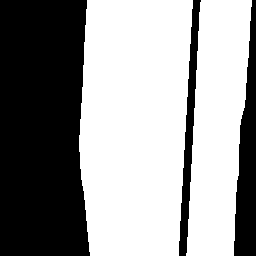

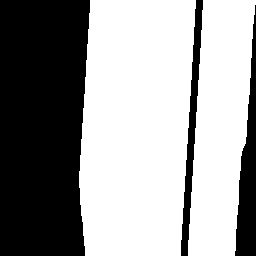

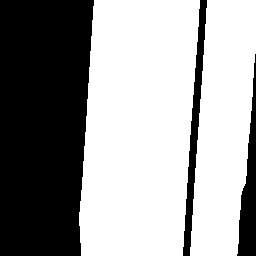

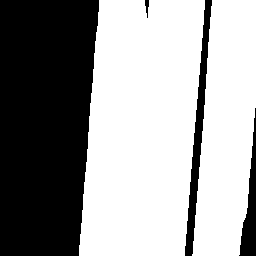

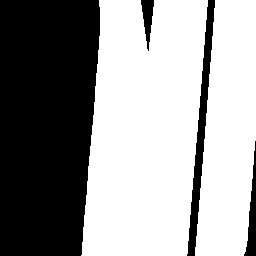

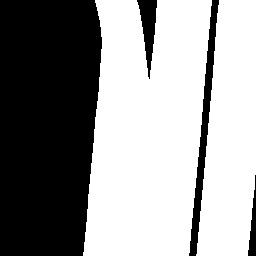

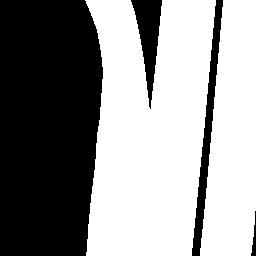

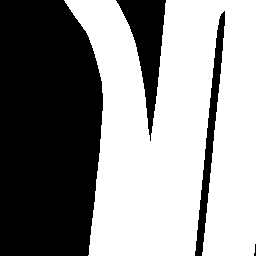

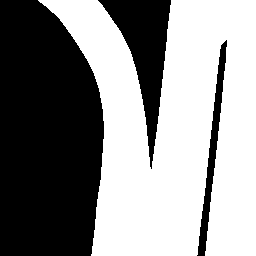

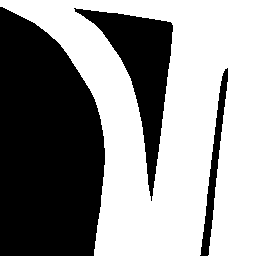

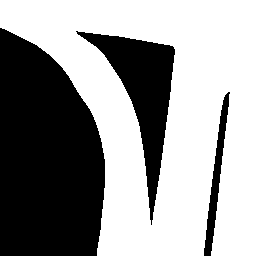

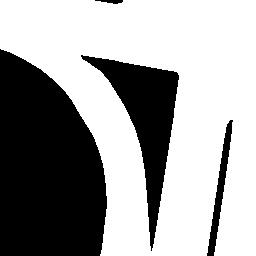

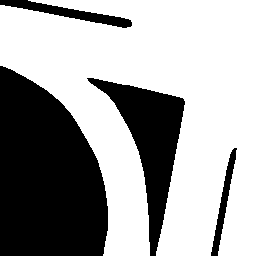

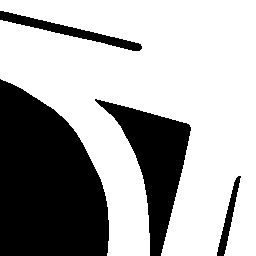

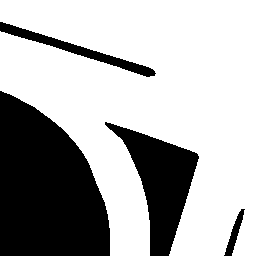

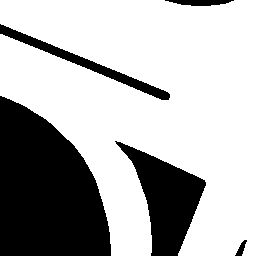

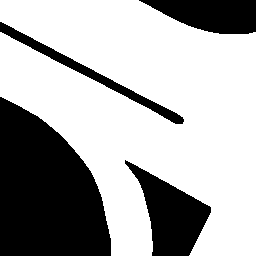

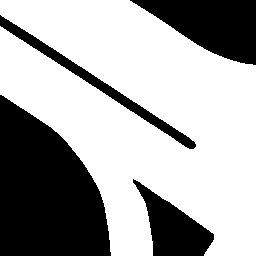

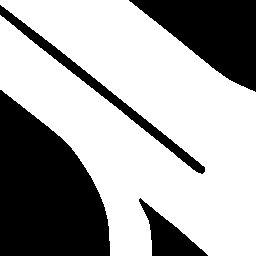

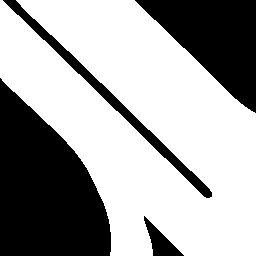

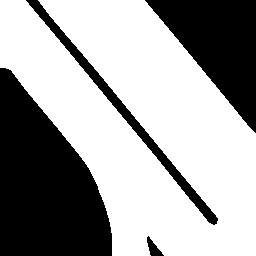

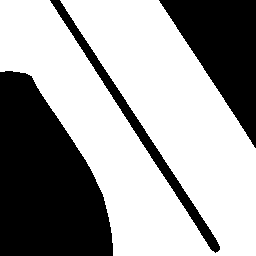

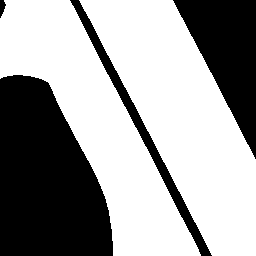

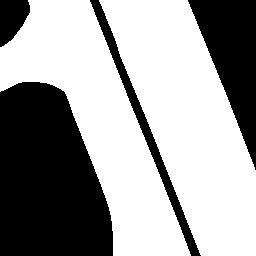

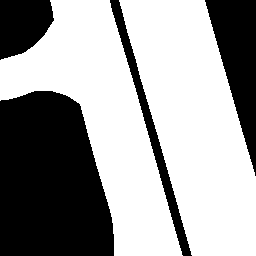

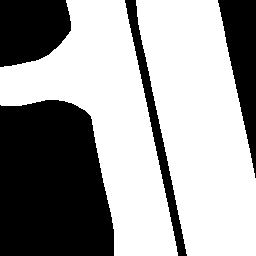

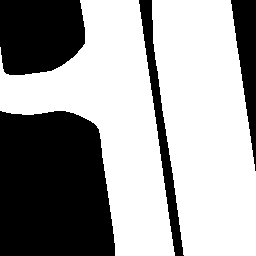

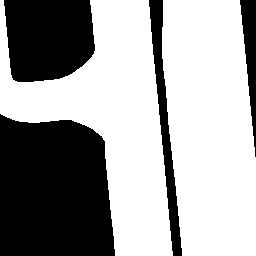

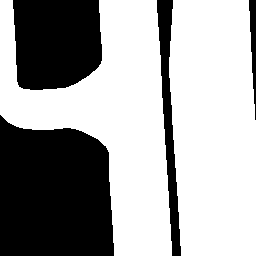

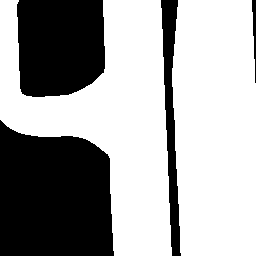

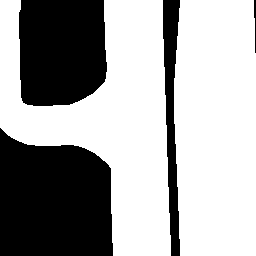

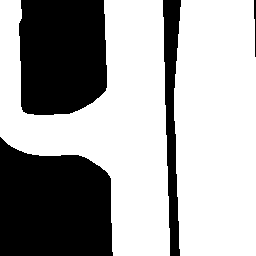

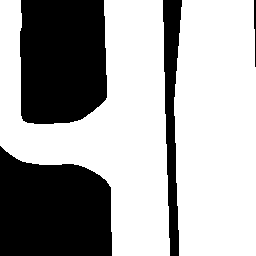

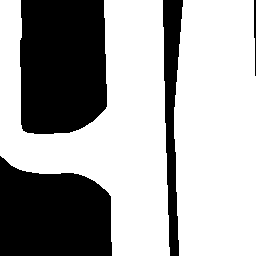

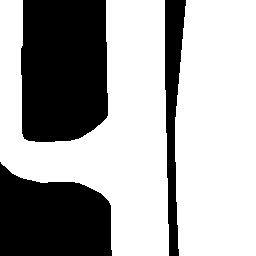

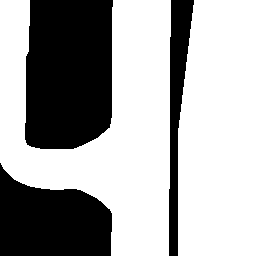

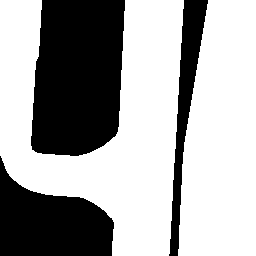

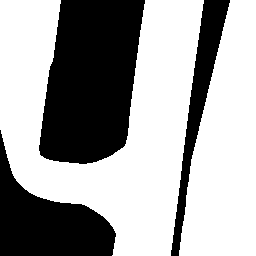

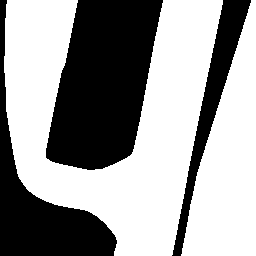

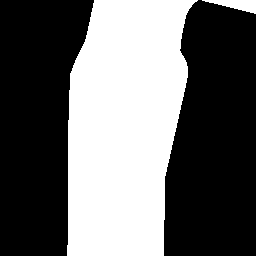

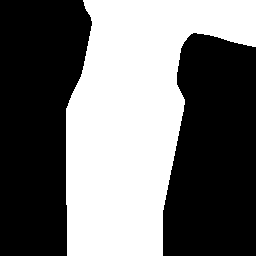

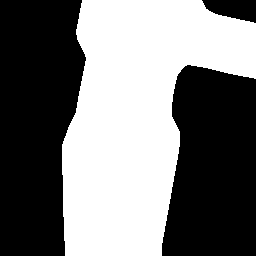

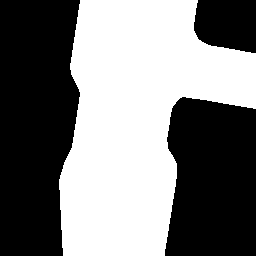

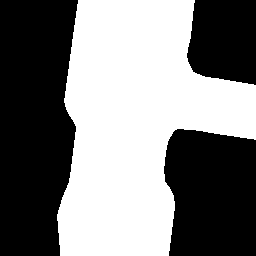

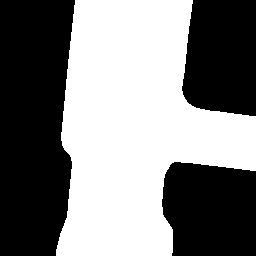

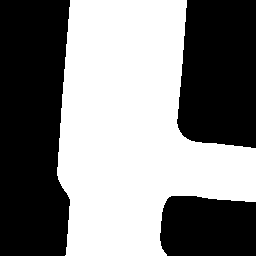

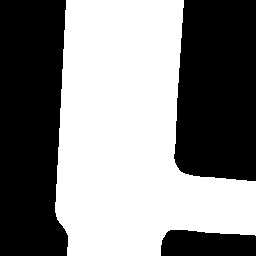

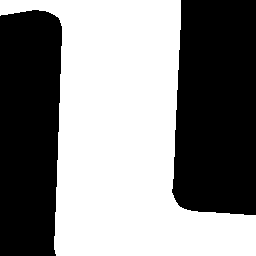

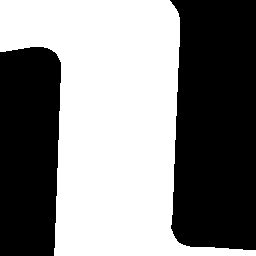

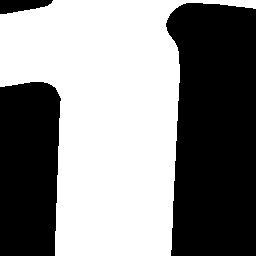

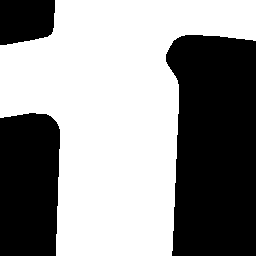

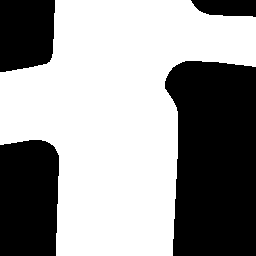

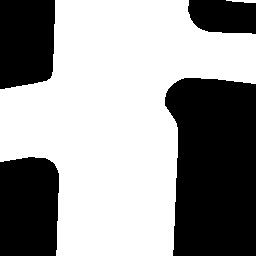

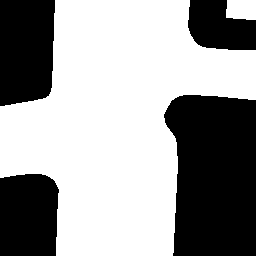

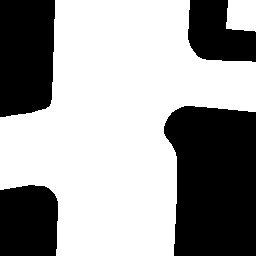

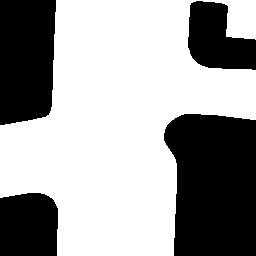

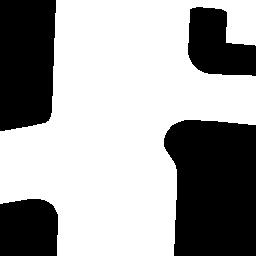

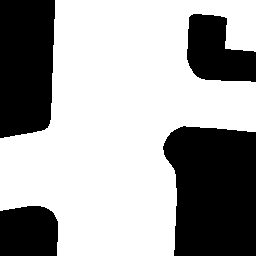

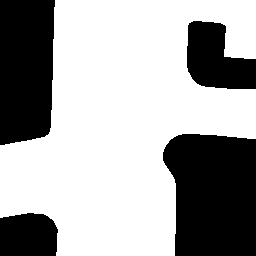

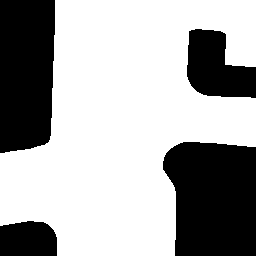

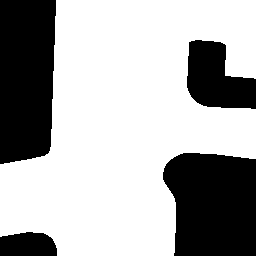

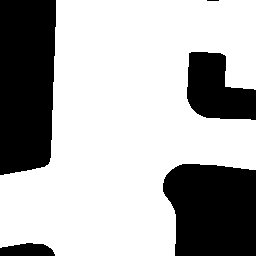

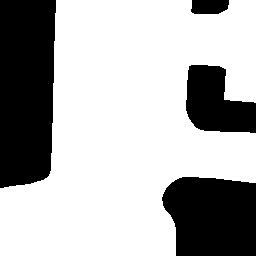

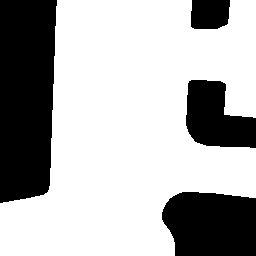

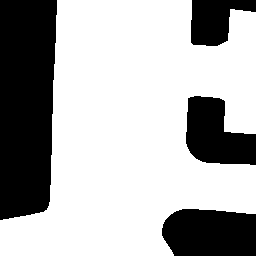

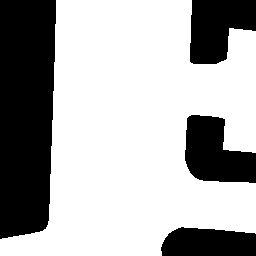

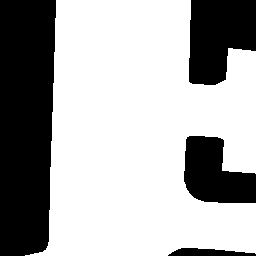

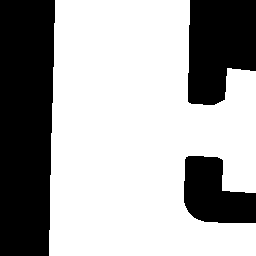

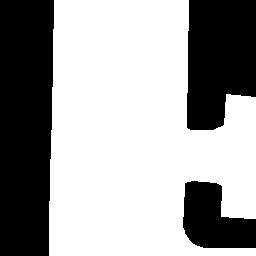

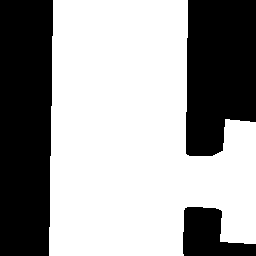

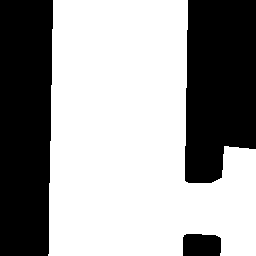

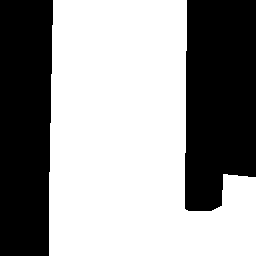

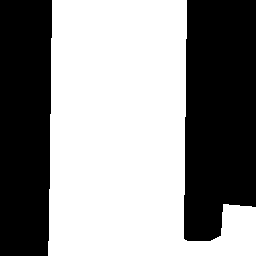

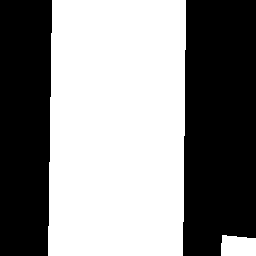

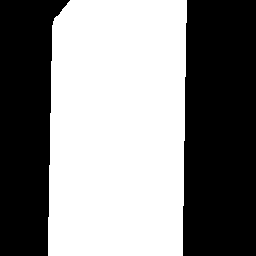

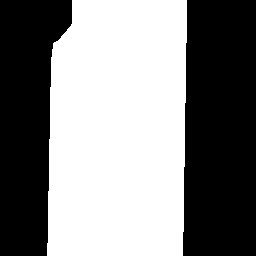

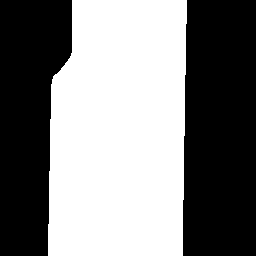

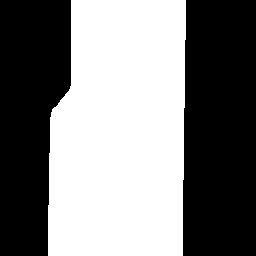

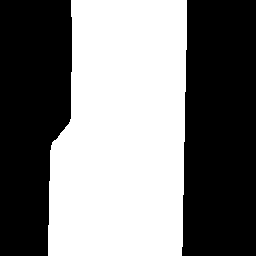

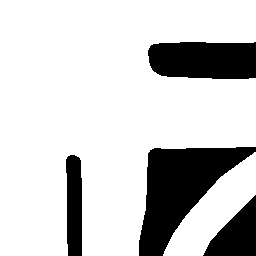

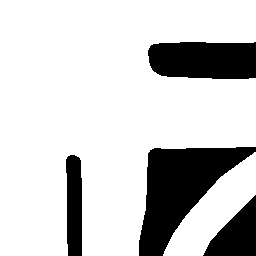

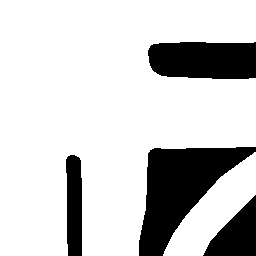

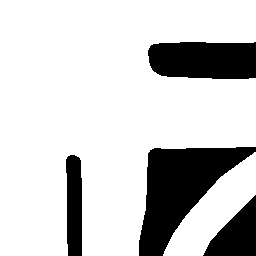

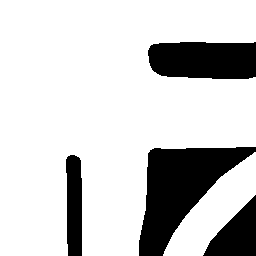

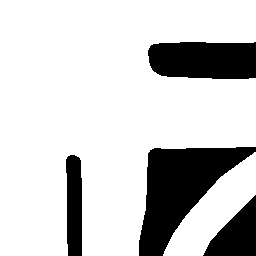

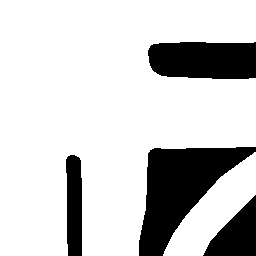

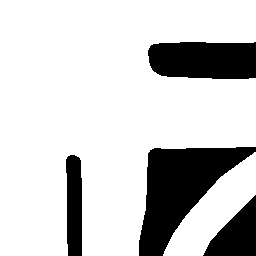

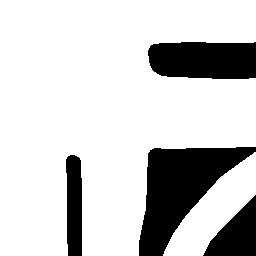

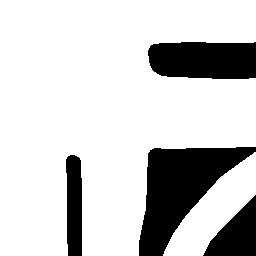

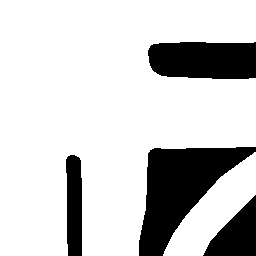

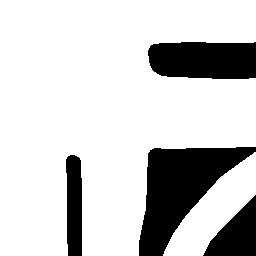

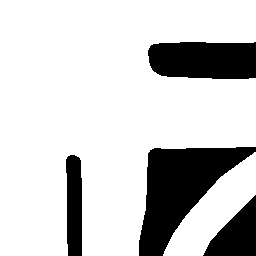

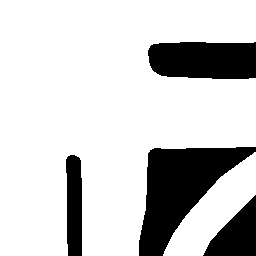

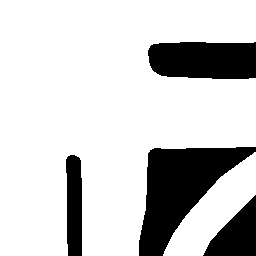

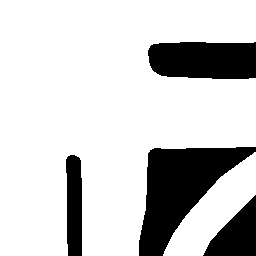

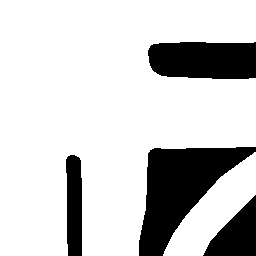

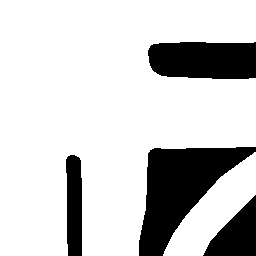

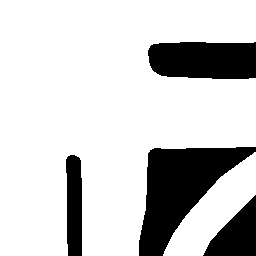

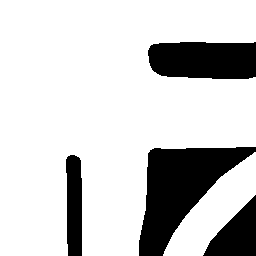

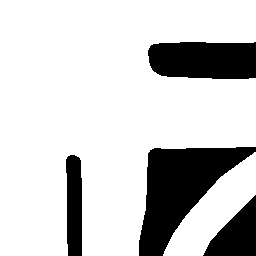

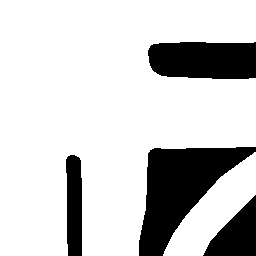

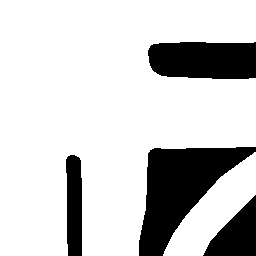

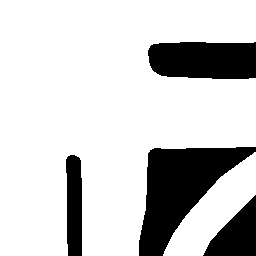

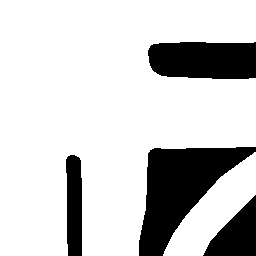

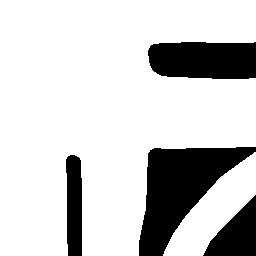

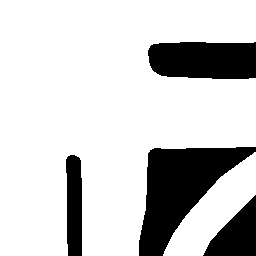

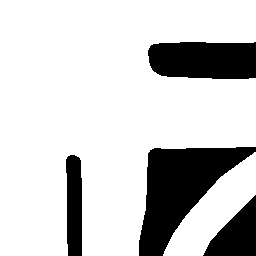

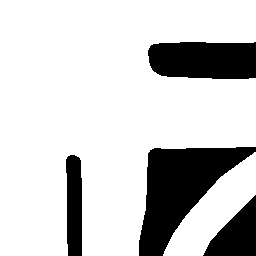

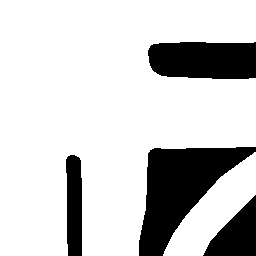

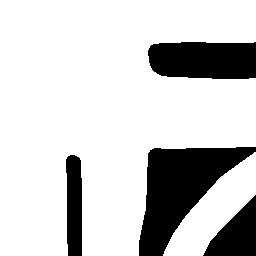

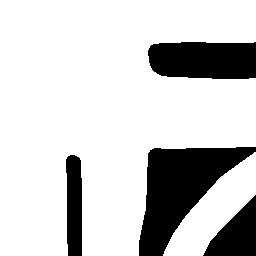

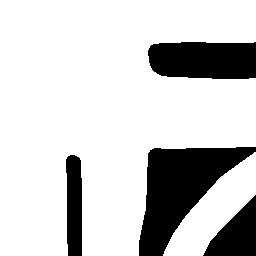

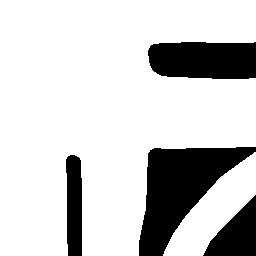

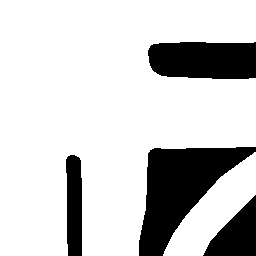

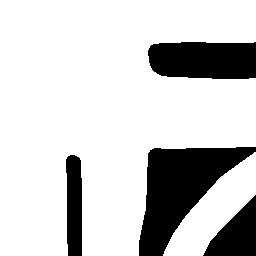

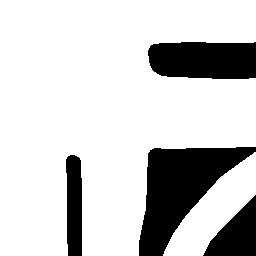

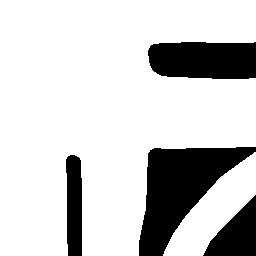

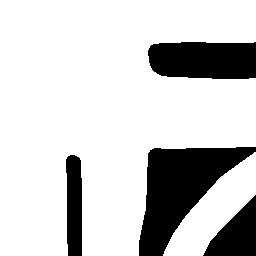

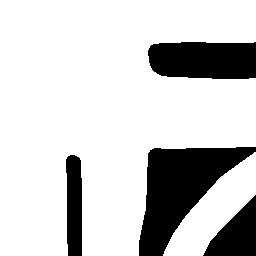

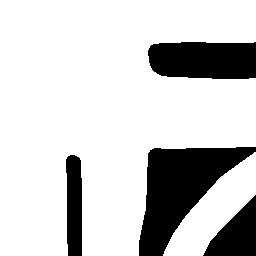

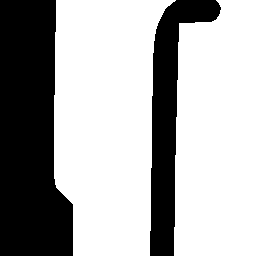

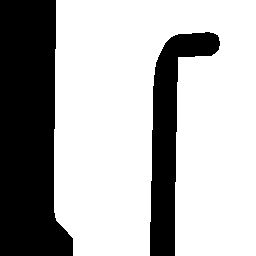

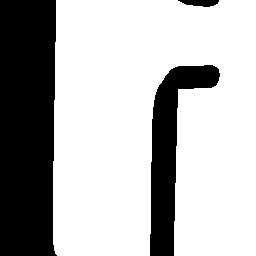

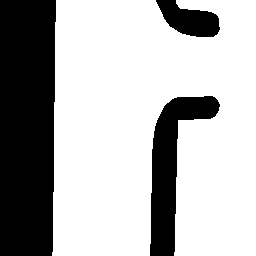

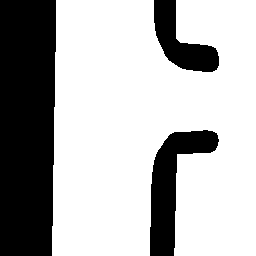

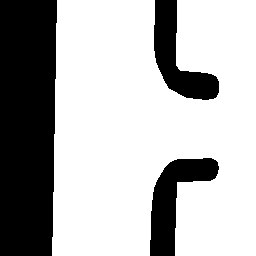

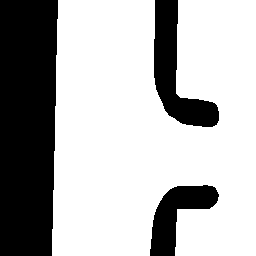

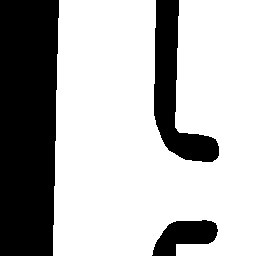

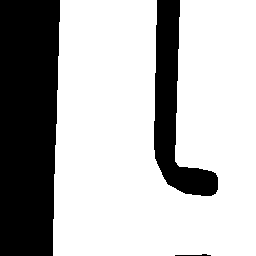

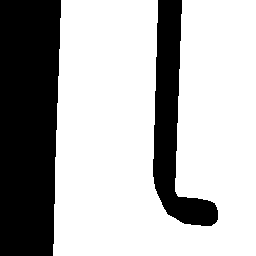

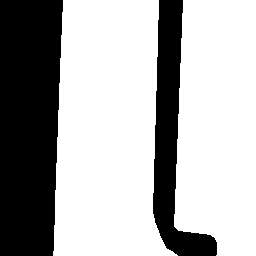

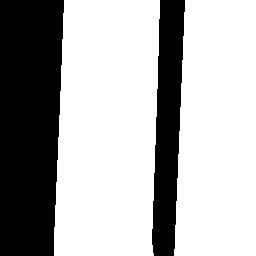

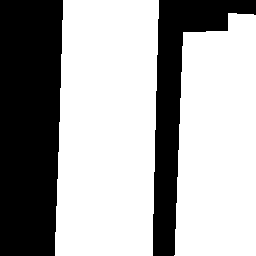

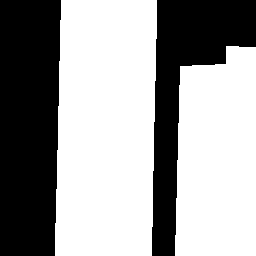

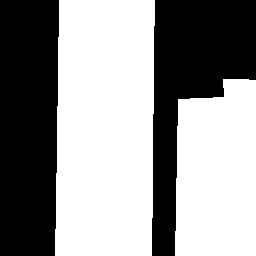

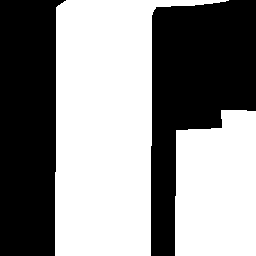

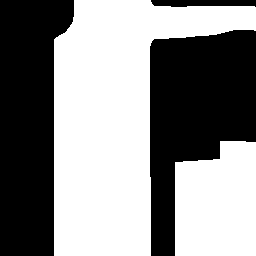

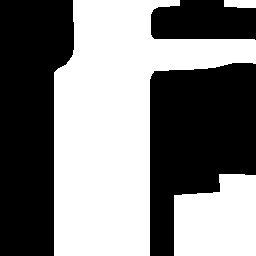

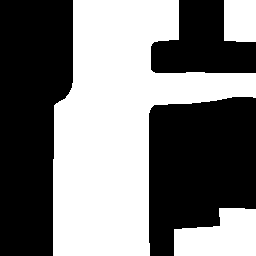

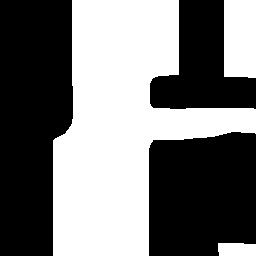

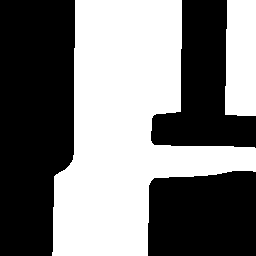

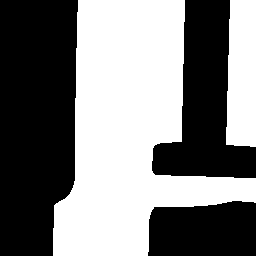

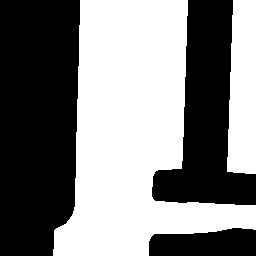

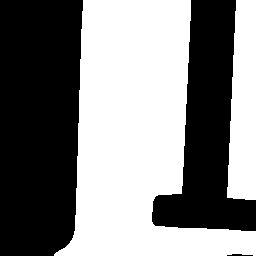

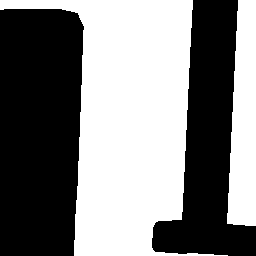

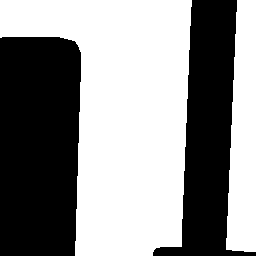

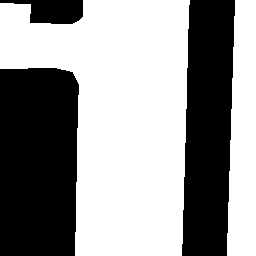

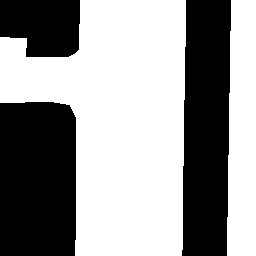

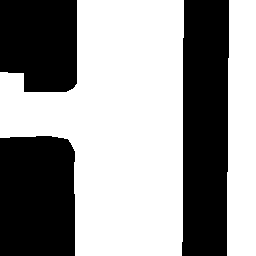

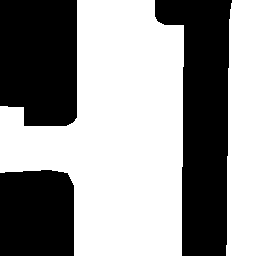

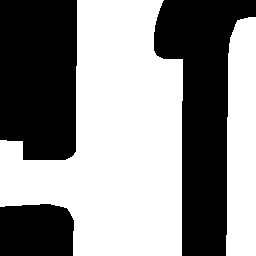

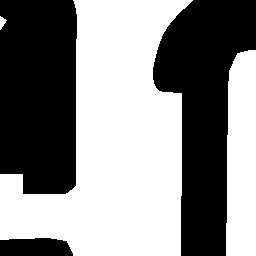

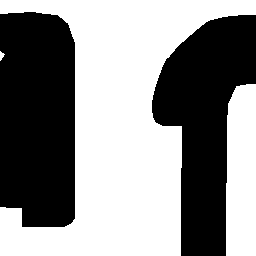

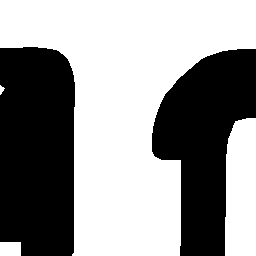

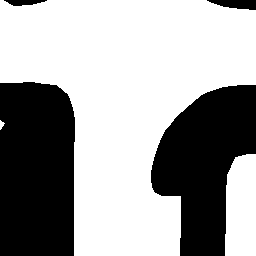

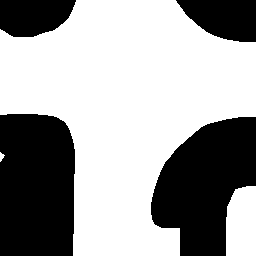

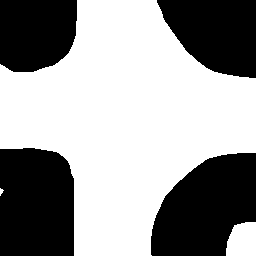

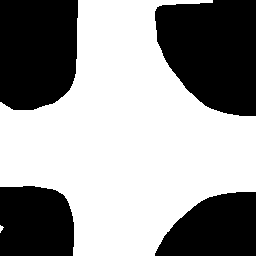

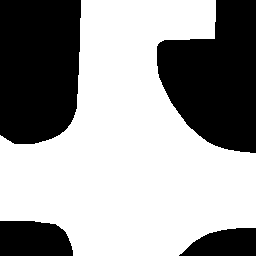

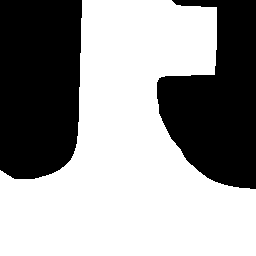

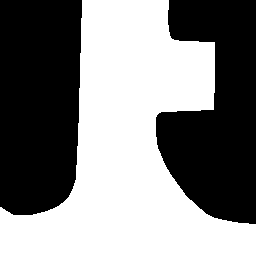

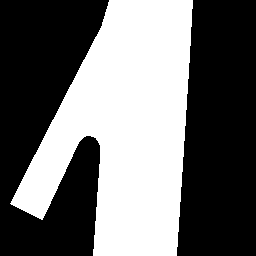

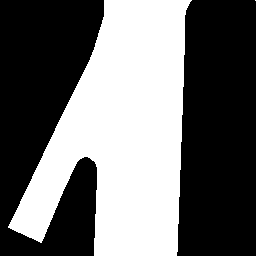

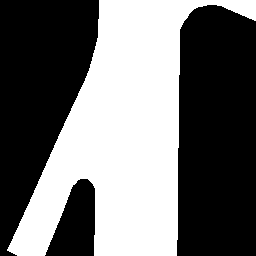

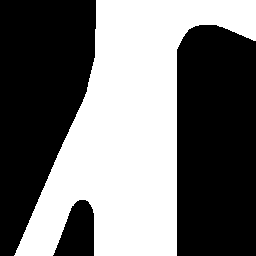

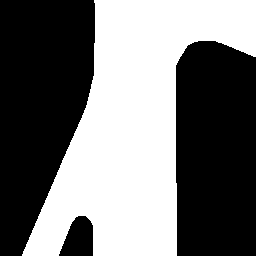

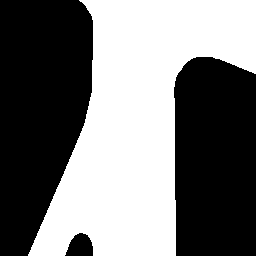

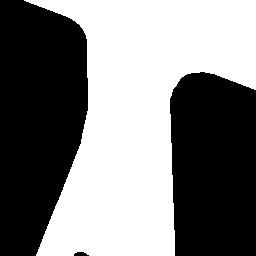

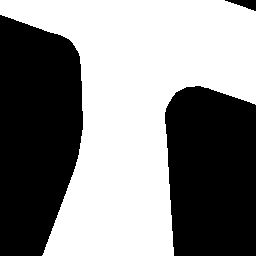

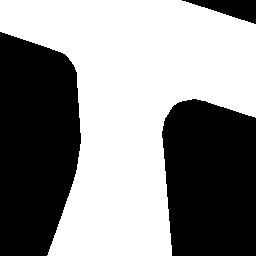

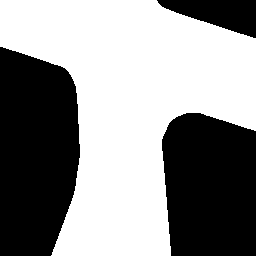

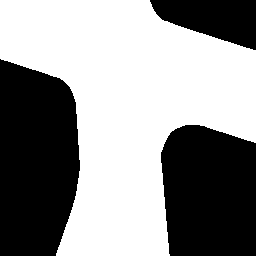

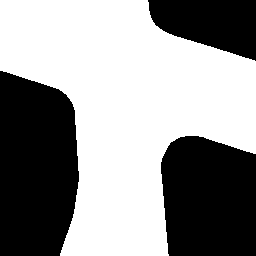

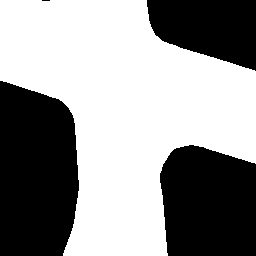

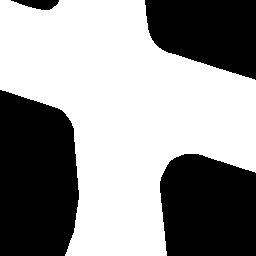

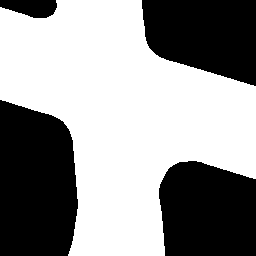

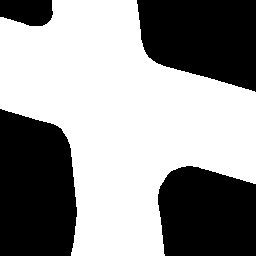

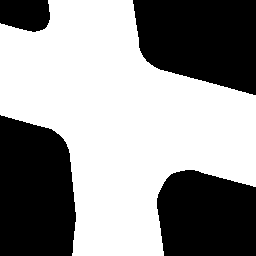

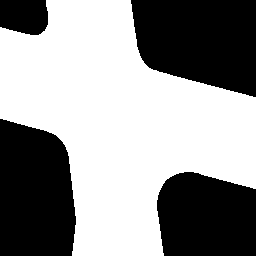

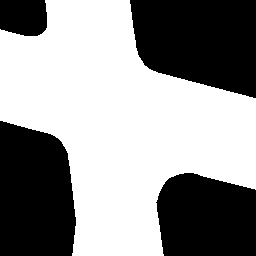

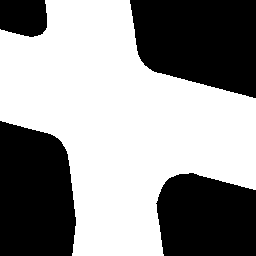

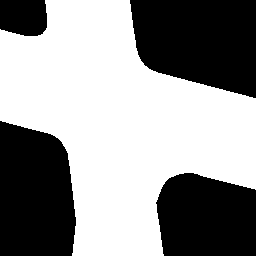

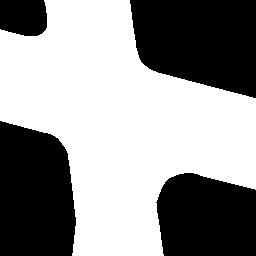

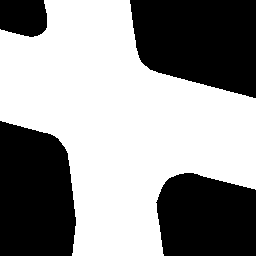

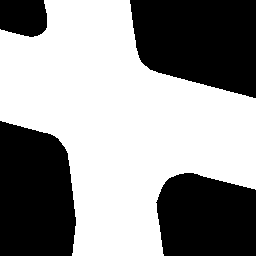

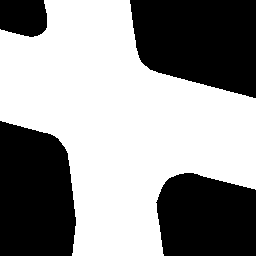

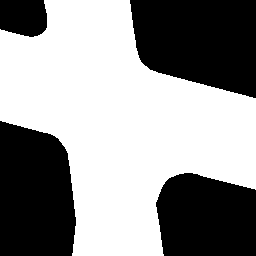

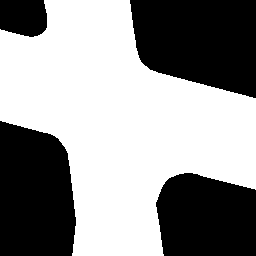

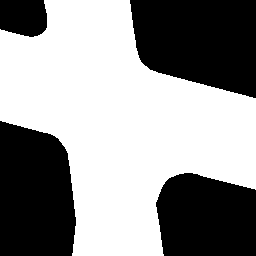

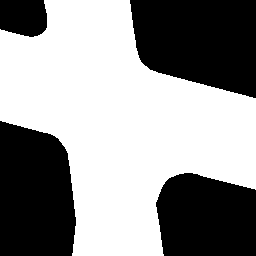

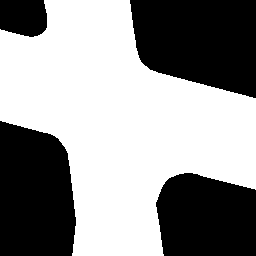

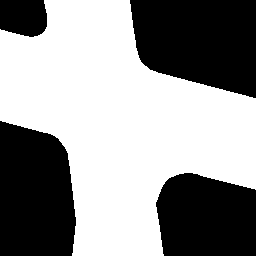

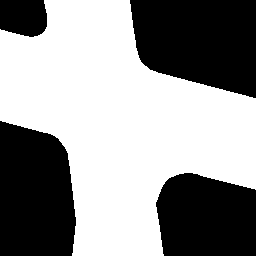

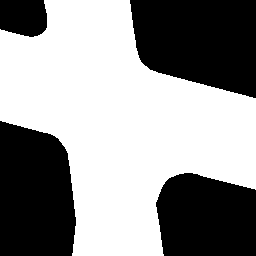

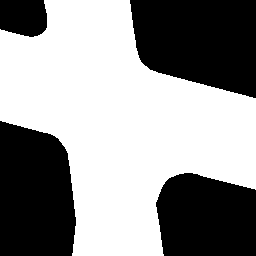

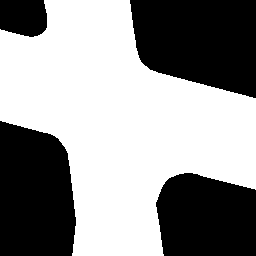

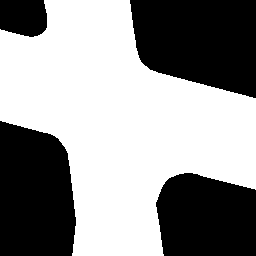

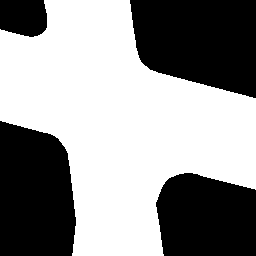

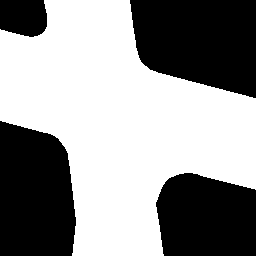

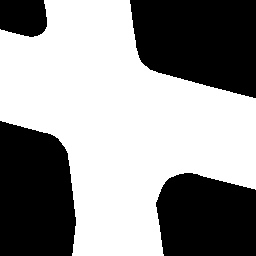

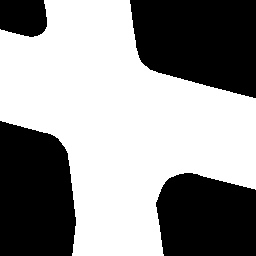

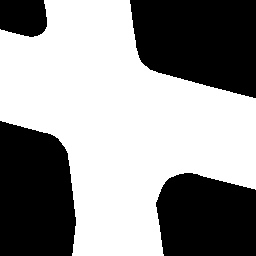

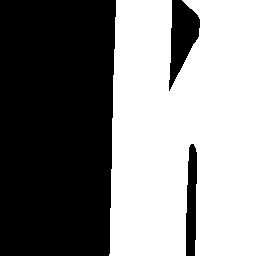

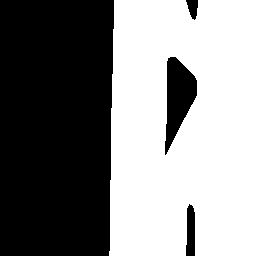

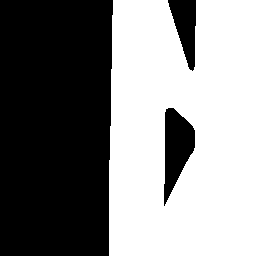

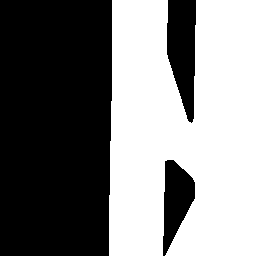

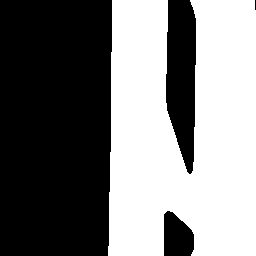

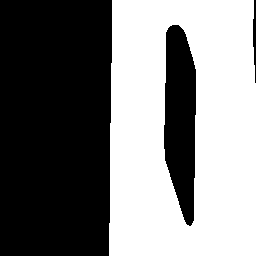

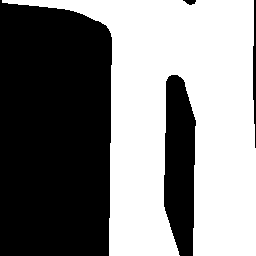

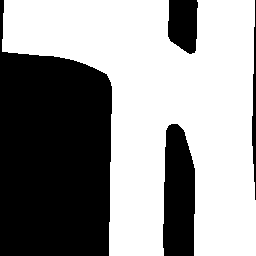

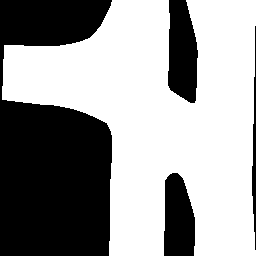

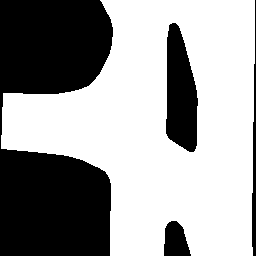

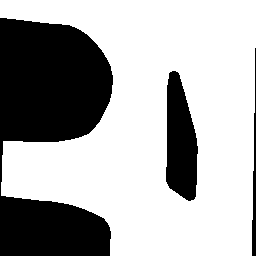

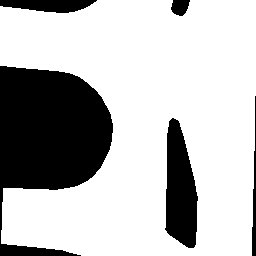

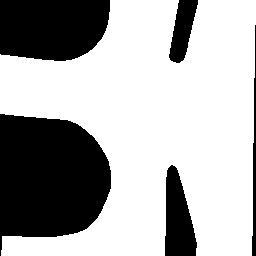

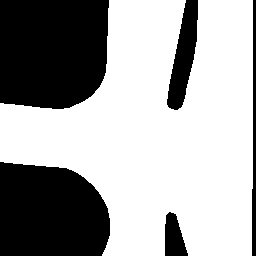

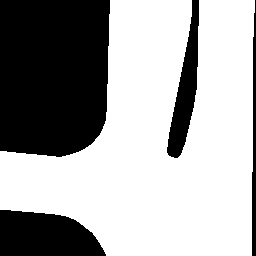

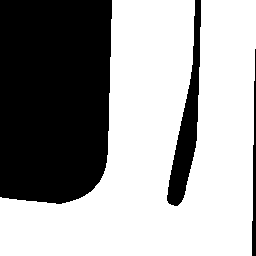

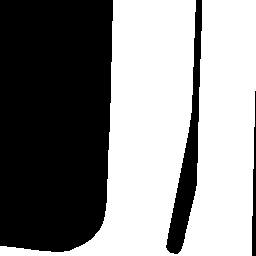

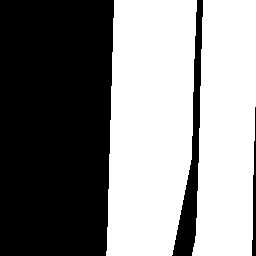

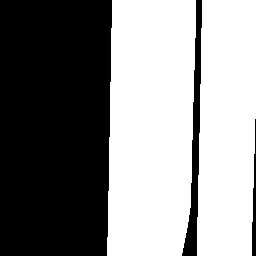

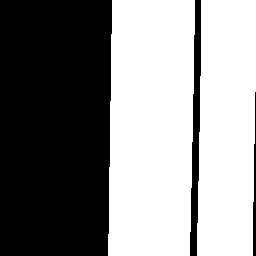

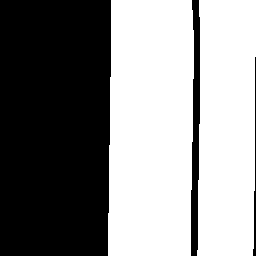

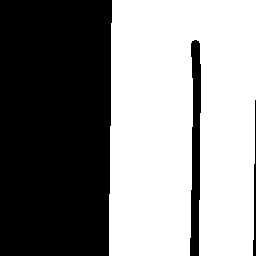

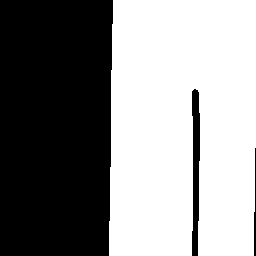

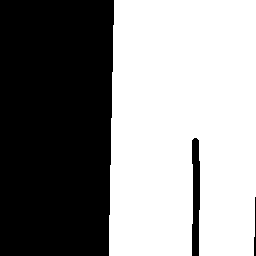

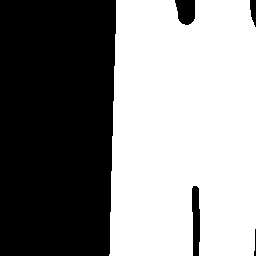

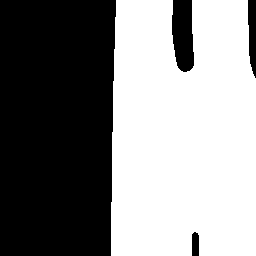

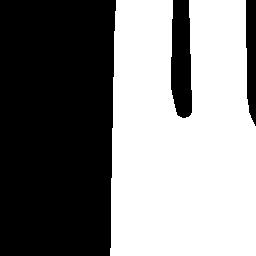

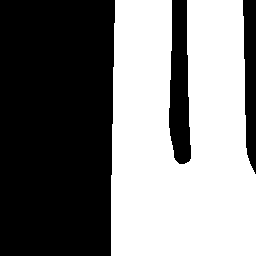

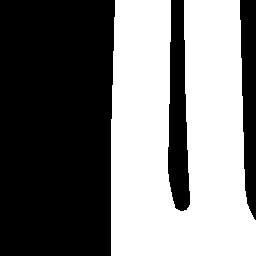

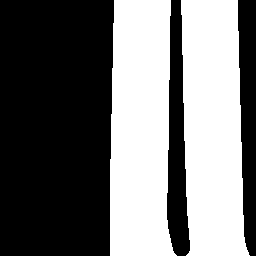

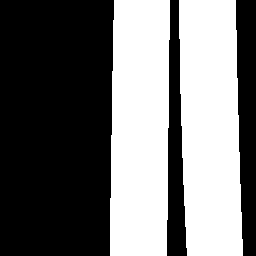

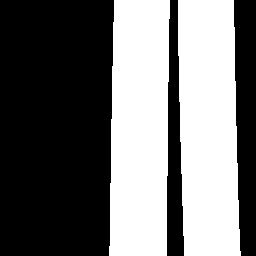

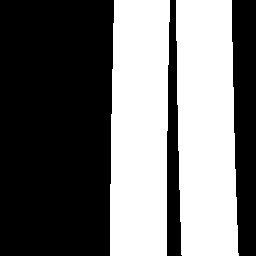

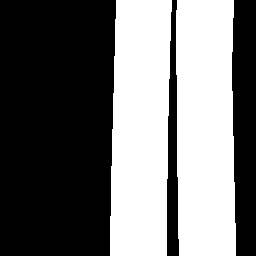

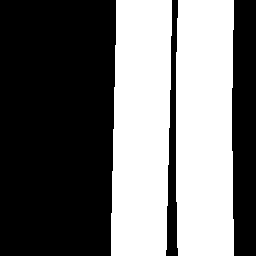

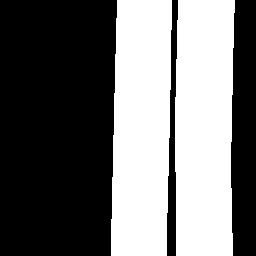

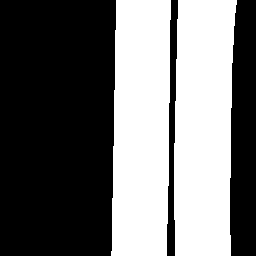

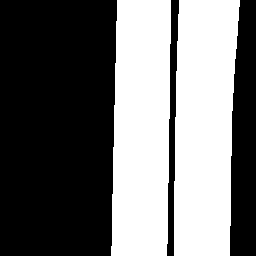

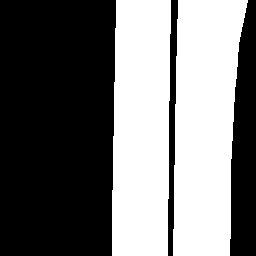

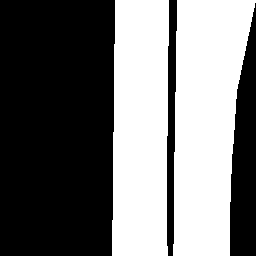

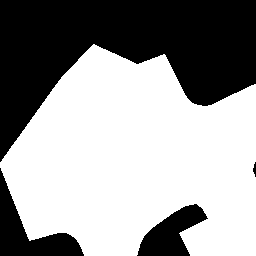

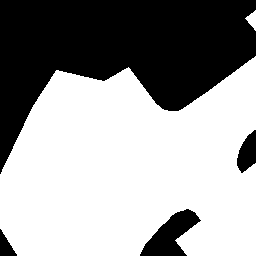

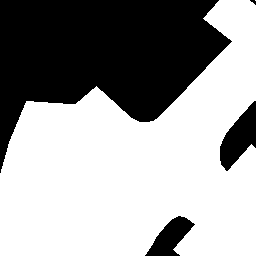

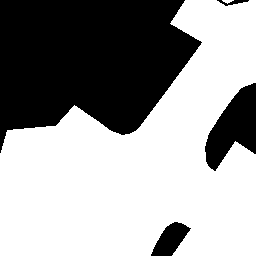

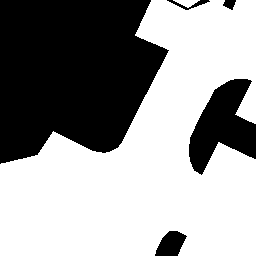

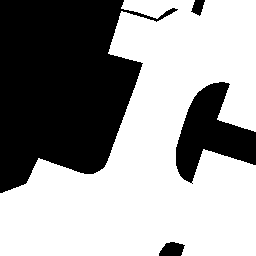

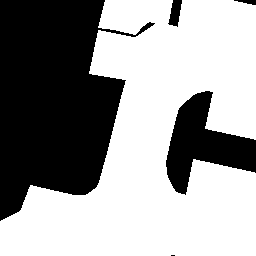

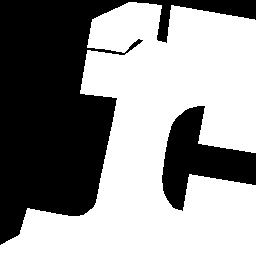

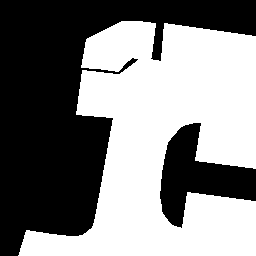

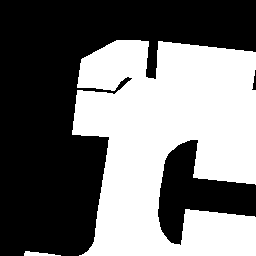

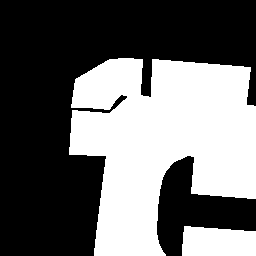

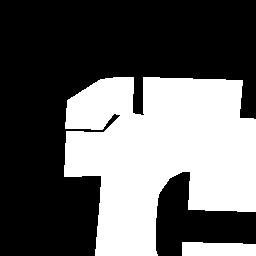

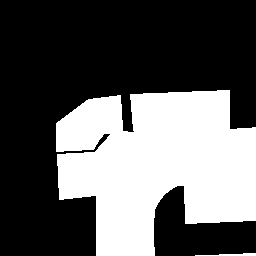

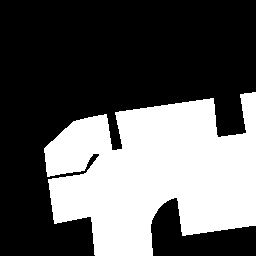

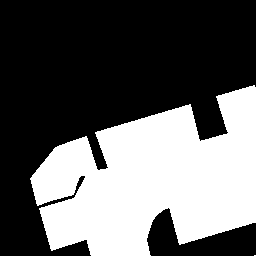

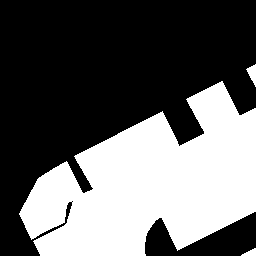

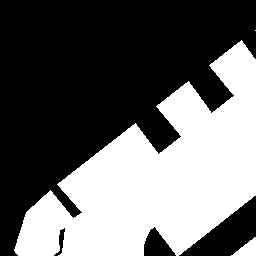

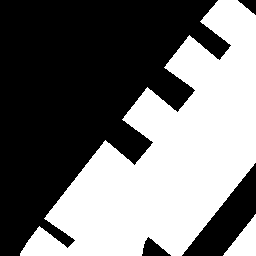

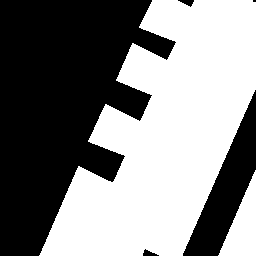

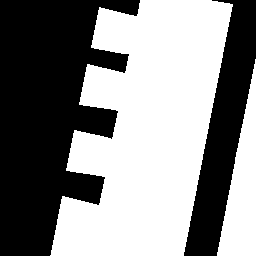

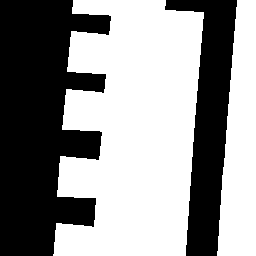

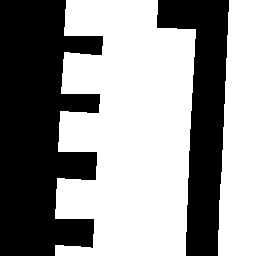

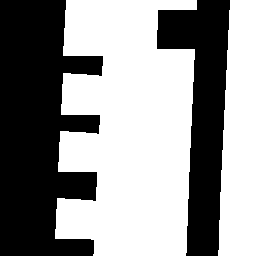

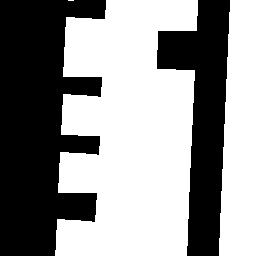

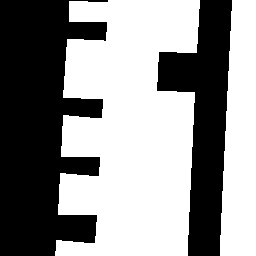

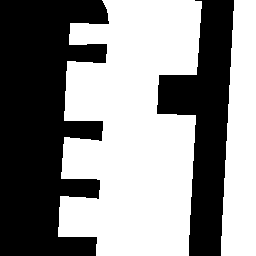

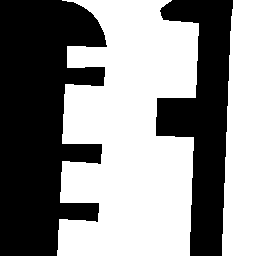

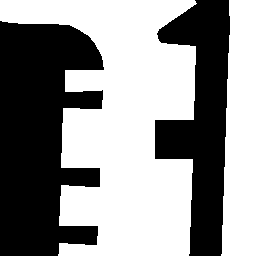

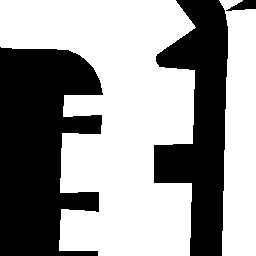

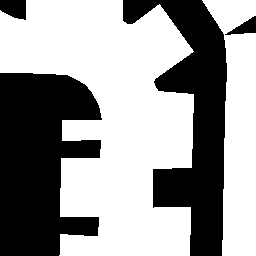

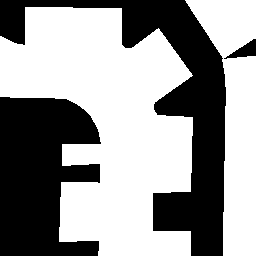

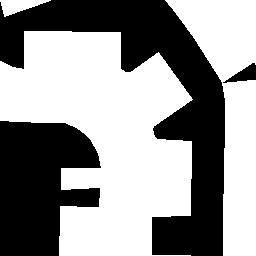

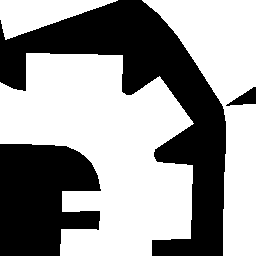

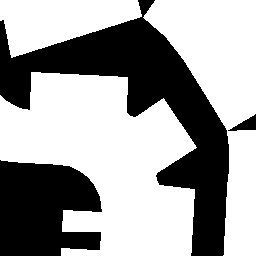

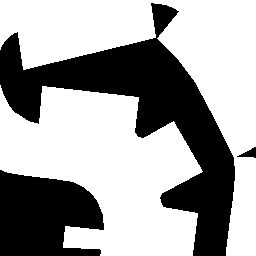

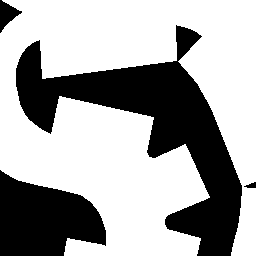

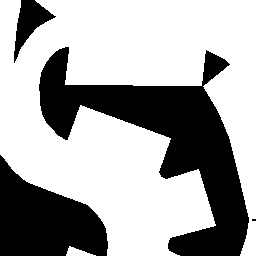

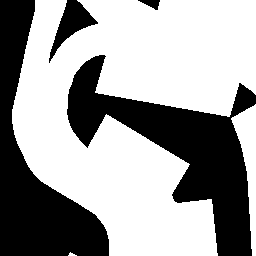

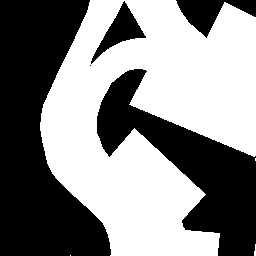

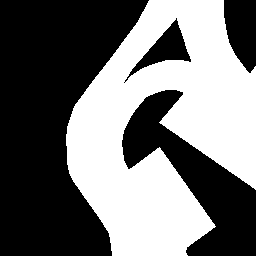

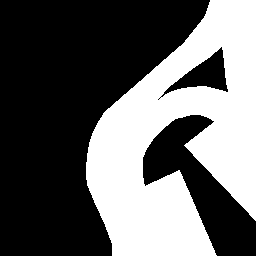

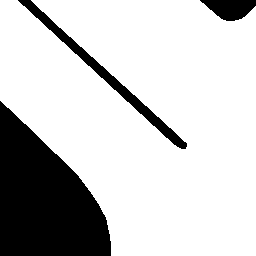

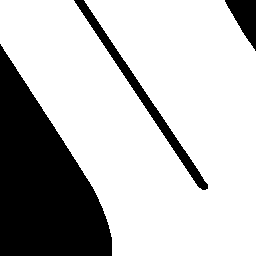

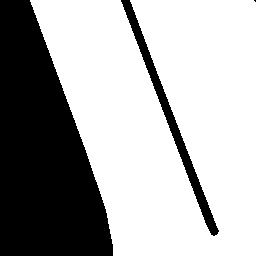

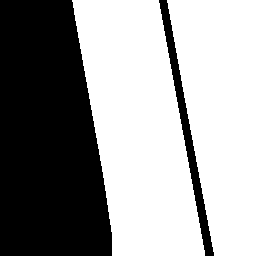

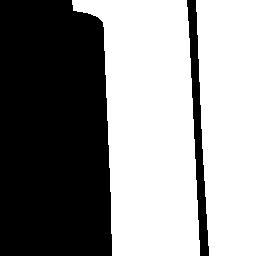

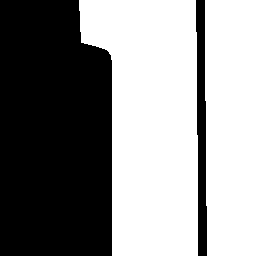

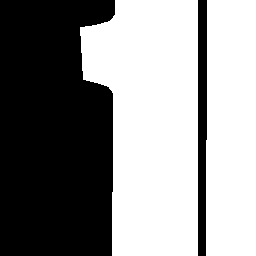

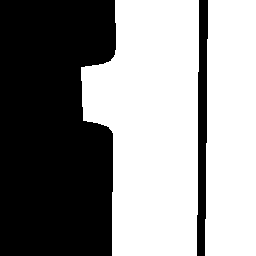

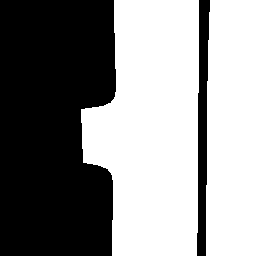

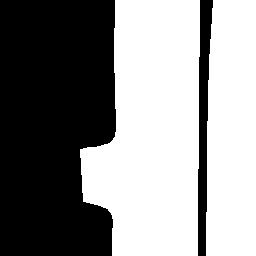

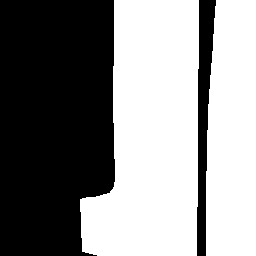

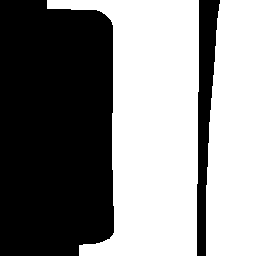

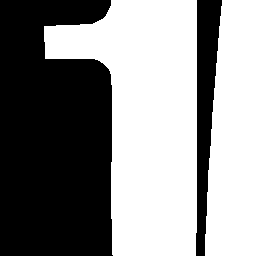

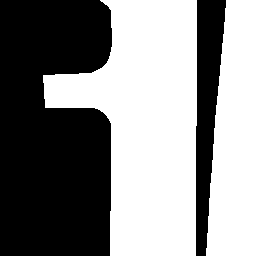

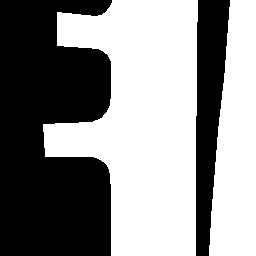

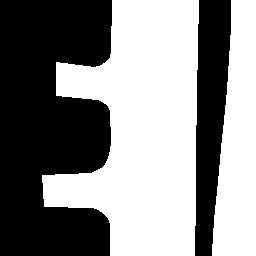

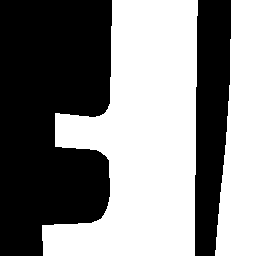

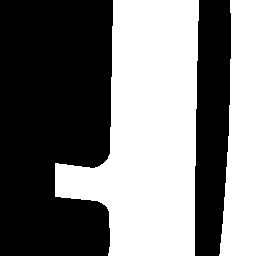

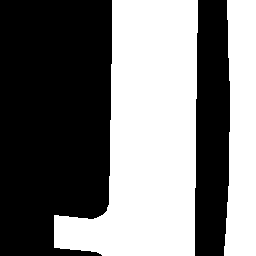

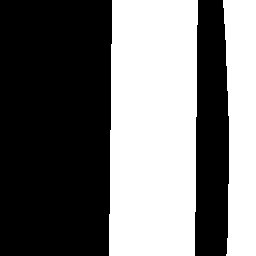

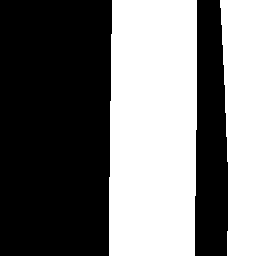

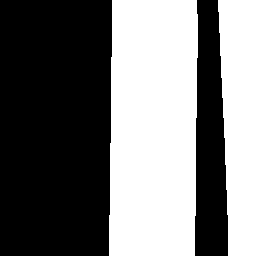

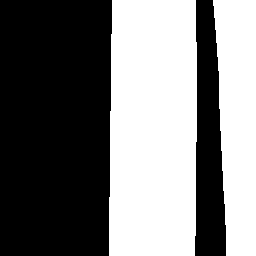

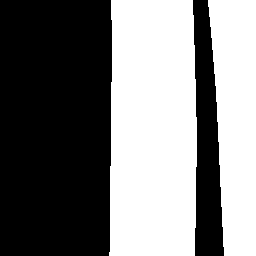

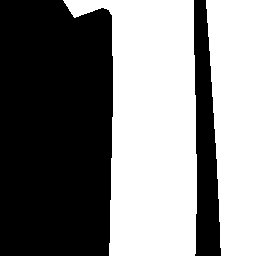

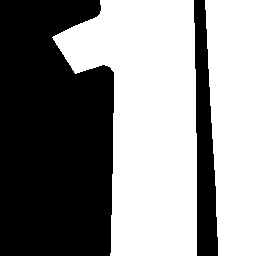

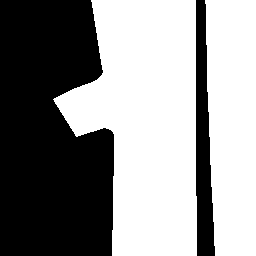

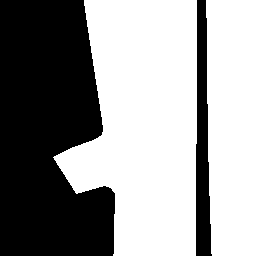

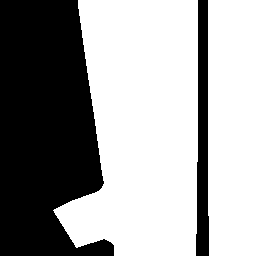

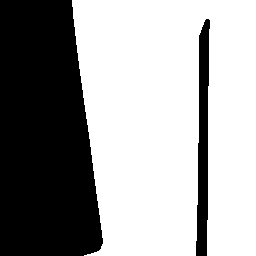

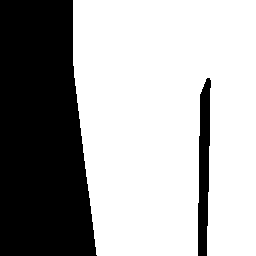

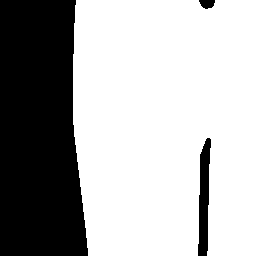

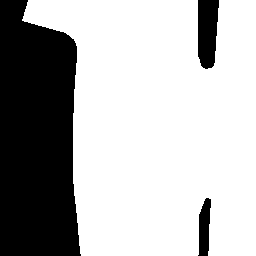

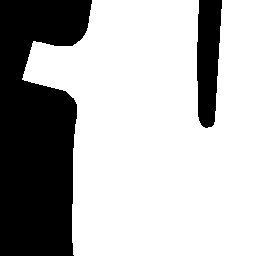

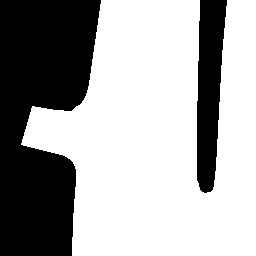

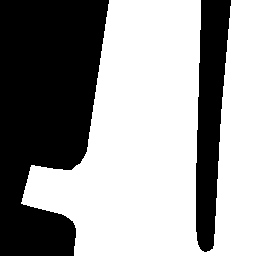

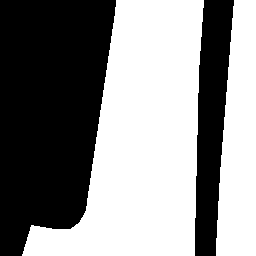

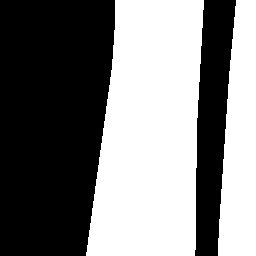

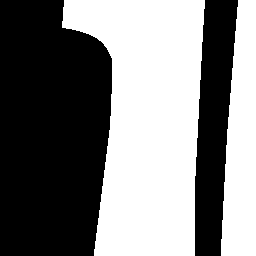

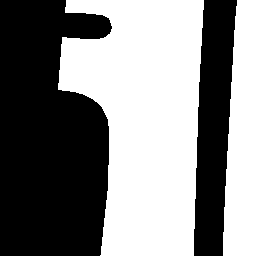

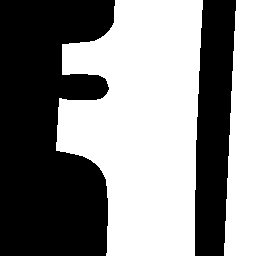

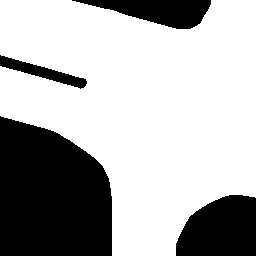

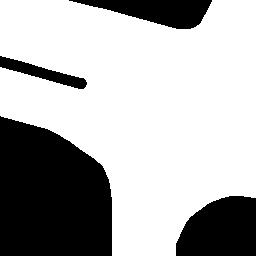

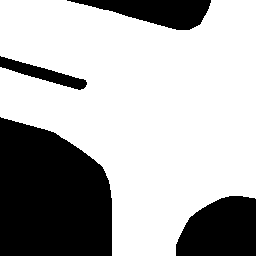

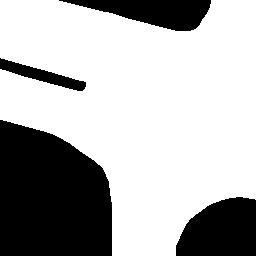

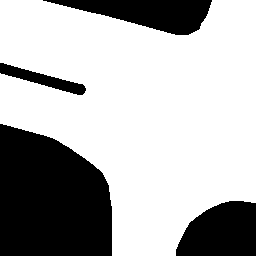

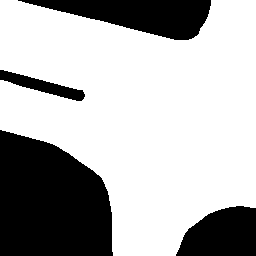

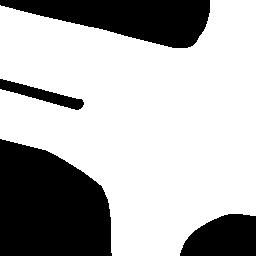

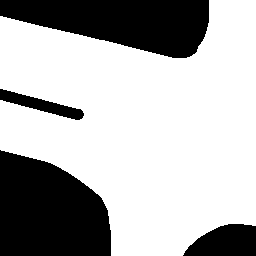

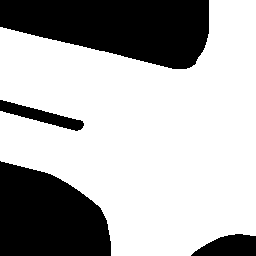

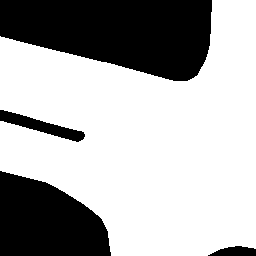

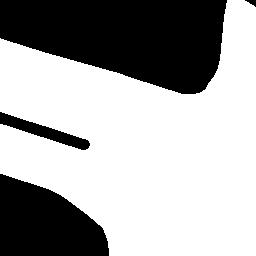

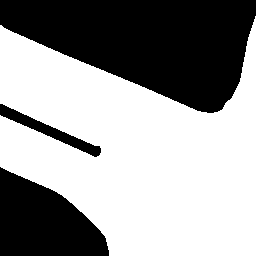

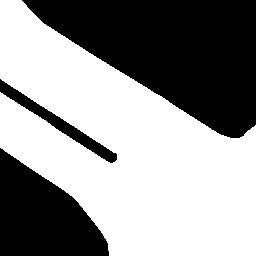

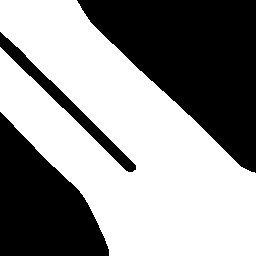

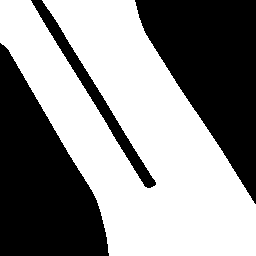

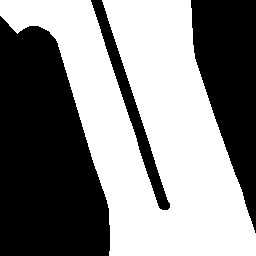

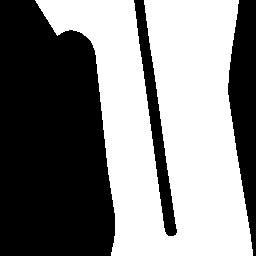

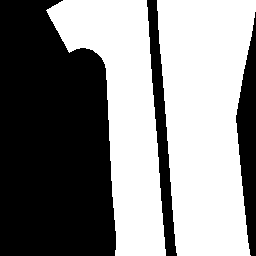

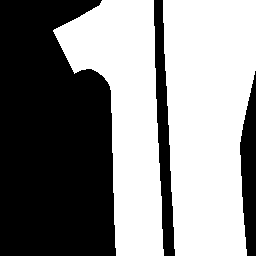

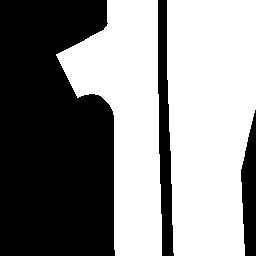

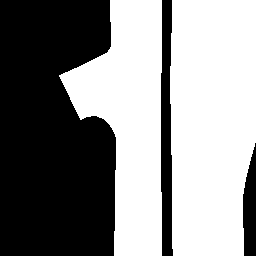

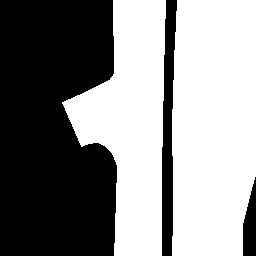

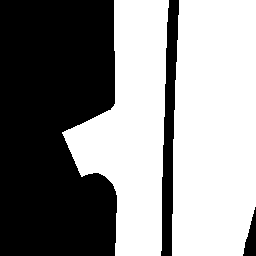

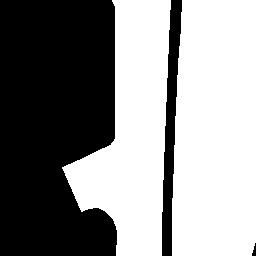

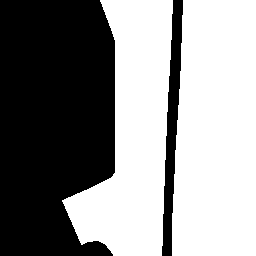

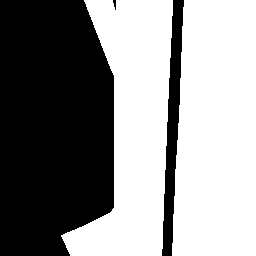

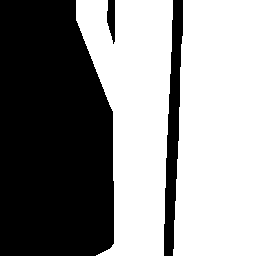

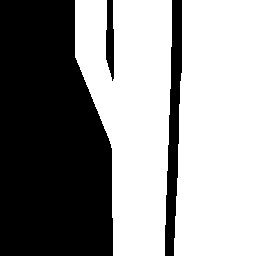

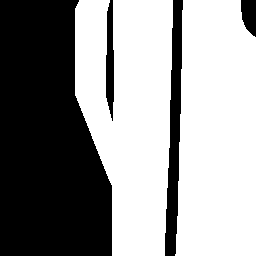

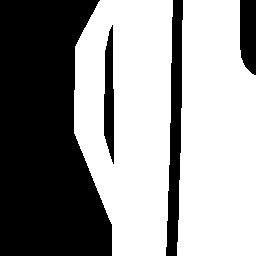

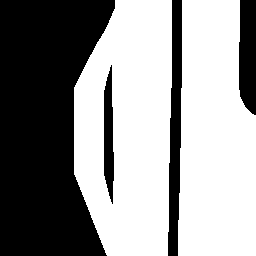

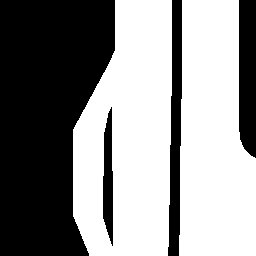

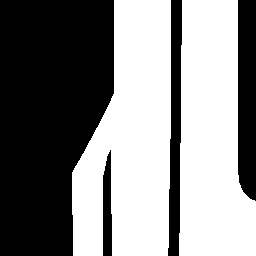

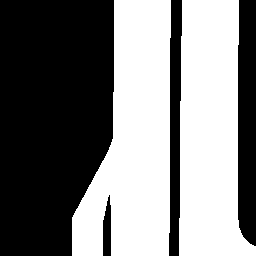

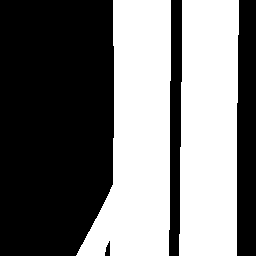

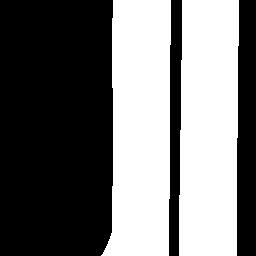

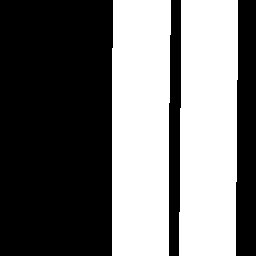

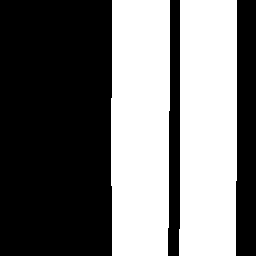

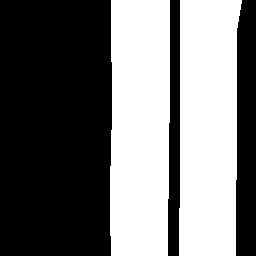

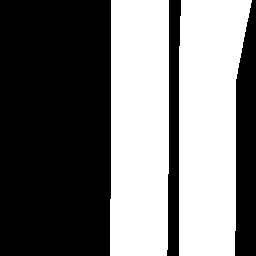

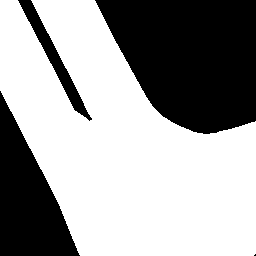

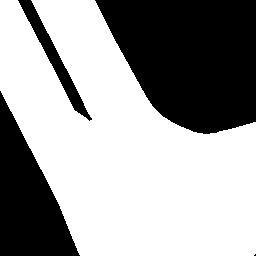

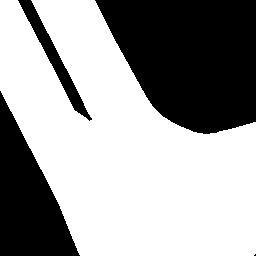

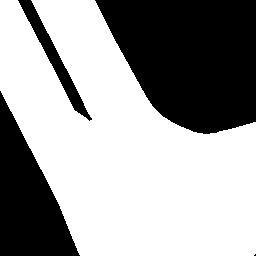

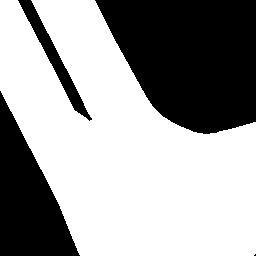

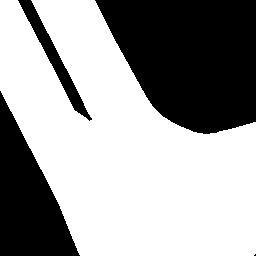

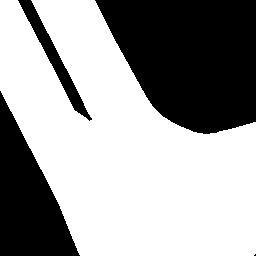

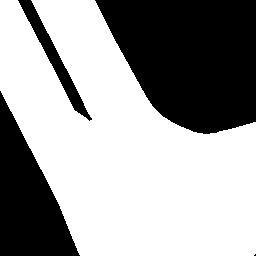

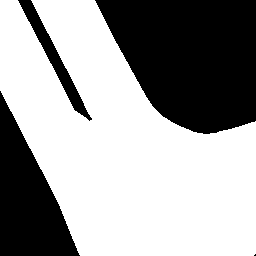

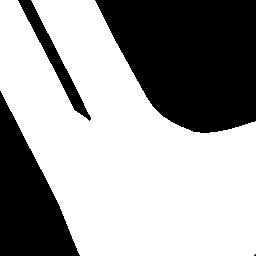

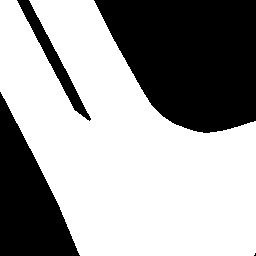

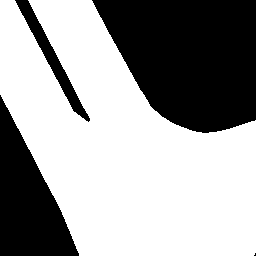

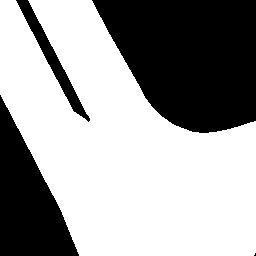

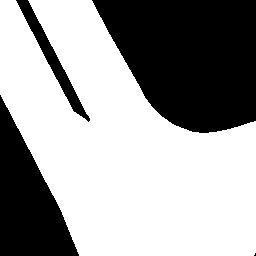

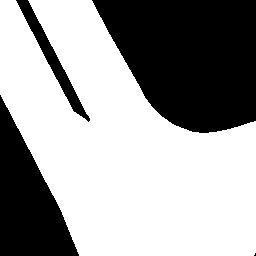

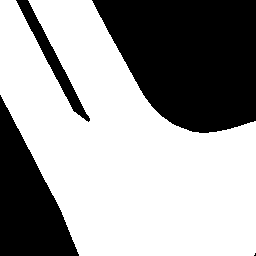

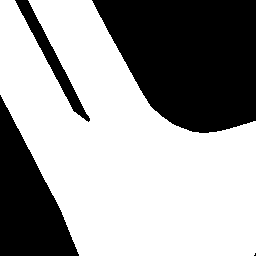

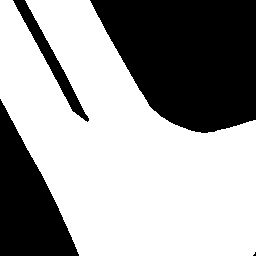

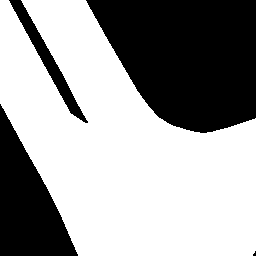

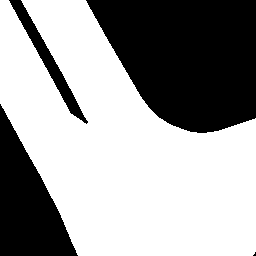

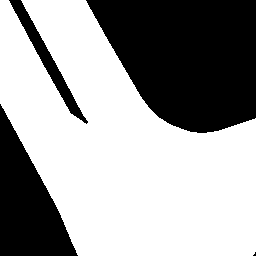

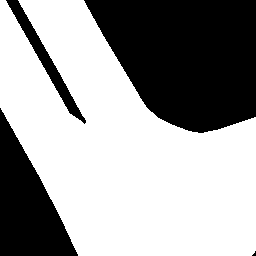

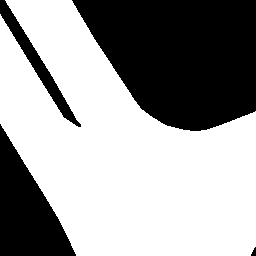

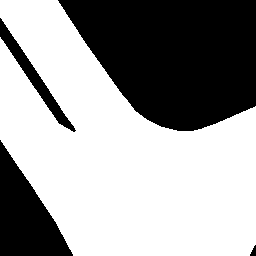

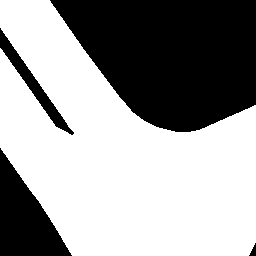

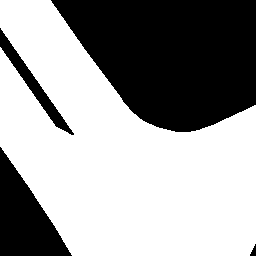

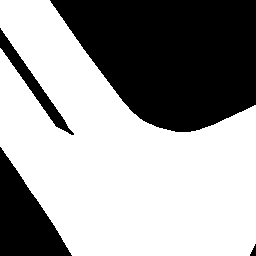

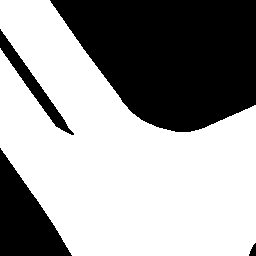

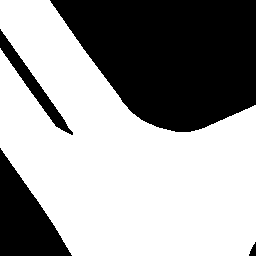

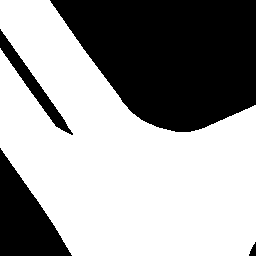

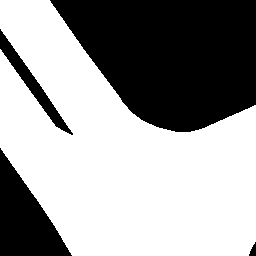

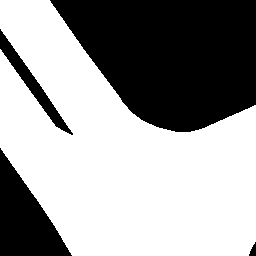

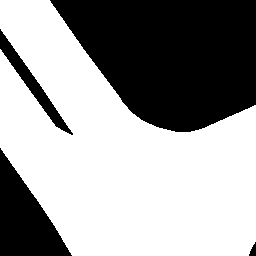

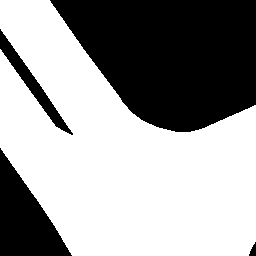

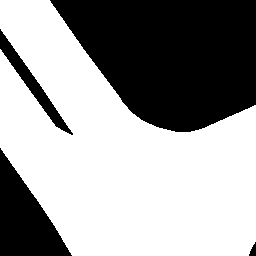

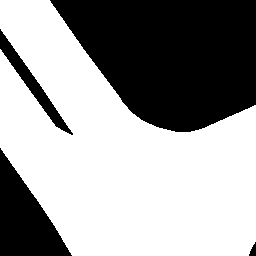

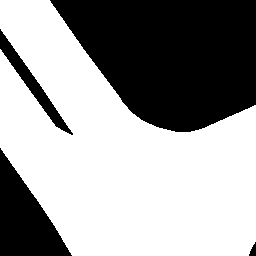

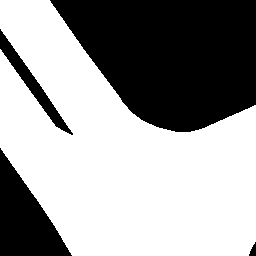

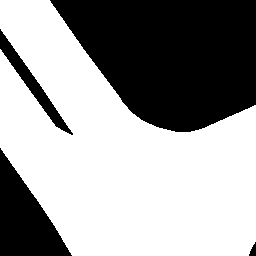

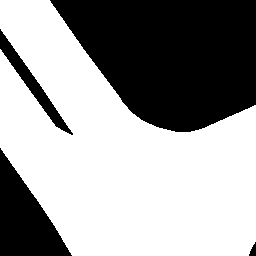

In [38]:
occ_width, occ_height = 256, 256
sensor = 'CAM_FRONT'

output_dir = f'{data_root}/static_gt'

if not os.path.exists(output_dir):
    os.makedirs(output_dir)

old_location = None

for sample in nusc.sample:
    my_sample = nusc.get('sample', sample['token'])

    cam_front_data = nusc.get('sample_data', my_sample['data'][sensor])
    ego_pose = nusc.get('ego_pose', cam_front_data['ego_pose_token'])
    cam_pose = nusc.get('calibrated_sensor', cam_front_data['calibrated_sensor_token'])
    scene = nusc.get('scene', my_sample['scene_token'])
    log = nusc.get('log', scene['log_token'])

    if old_location != log['location']:
        nusc_map = NuScenesMap(dataroot=data_root, map_name=log['location'])
        old_location = log['location']

    scale = 32

    patch_box = [
        ego_pose['translation'][0],
        ego_pose['translation'][1],
        2 * scale,
        2 * scale
    ]
    patch_angle = get_mask_angle(ego_pose, cam_pose)
    layer_names = ['drivable_area']


    map_mask = nusc_map.get_map_mask(patch_box, patch_angle, layer_names, (2 * occ_width, 2 * occ_height))[0]
    map_mask = map_mask[:occ_height, int(occ_width / 2): -int((occ_width + 1) / 2)]

    map_mask = np.flip(map_mask, 1)

    img = Image.fromarray(map_mask * 255)
    img.show()
    # nusc.render_sample_data(cam_front_data['token'])
    img.save(os.path.join(output_dir, cam_front_data['filename'].split('/')[-1]))

    # break